In [4]:
# import things

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, concatenate, BatchNormalization
)
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [3]:
# REQUIREMENT: Do not add code from Tasks 2 or 4
# REQUIREMENT: All dataset prep (crop/pad/patch/directory structure) must be finalize before attempting this task.
patch_size = 256  # Example patch size
batch_size = 32
main_seed = 42
patch_dir = 'Y2B_24/split_patches'

In [4]:
# F1 Score Metric
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives + K.epsilon())
        return recall

    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives + K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [2]:
# Updated U-Net Model
def advanced_unet_model_v2(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = tf.keras.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    # Downsampling path
    c1 = Conv2D(16, (3, 3), padding='same')(inputs)
    c1 = tf.keras.layers.LeakyReLU(alpha=0.1)(c1)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(16, (3, 3), padding='same')(c1)
    c1 = tf.keras.layers.LeakyReLU(alpha=0.1)(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), padding='same')(p1)
    c2 = tf.keras.layers.LeakyReLU(alpha=0.1)(c2)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.3)(c2)
    c2 = Conv2D(32, (3, 3), padding='same')(c2)
    c2 = tf.keras.layers.LeakyReLU(alpha=0.1)(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), padding='same')(p2)
    c3 = tf.keras.layers.LeakyReLU(alpha=0.1)(c3)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.4)(c3)
    c3 = Conv2D(64, (3, 3), padding='same')(c3)
    c3 = tf.keras.layers.LeakyReLU(alpha=0.1)(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), padding='same')(p3)
    c4 = tf.keras.layers.LeakyReLU(alpha=0.1)(c4)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.5)(c4)
    c4 = Conv2D(128, (3, 3), padding='same')(c4)
    c4 = tf.keras.layers.LeakyReLU(alpha=0.1)(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(256, (3, 3), padding='same')(p4)
    c5 = tf.keras.layers.LeakyReLU(alpha=0.1)(c5)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(0.5)(c5)
    c5 = Conv2D(256, (3, 3), padding='same')(c5)
    c5 = tf.keras.layers.LeakyReLU(alpha=0.1)(c5)
    c5 = BatchNormalization()(c5)

    # Upsampling path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), padding='same')(u6)
    c6 = tf.keras.layers.LeakyReLU(alpha=0.1)(c6)
    c6 = BatchNormalization()(c6)
    c6 = Dropout(0.4)(c6)
    c6 = Conv2D(128, (3, 3), padding='same')(c6)
    c6 = tf.keras.layers.LeakyReLU(alpha=0.1)(c6)
    c6 = BatchNormalization()(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), padding='same')(u7)
    c7 = tf.keras.layers.LeakyReLU(alpha=0.1)(c7)
    c7 = BatchNormalization()(c7)
    c7 = Dropout(0.3)(c7)
    c7 = Conv2D(64, (3, 3), padding='same')(c7)
    c7 = tf.keras.layers.LeakyReLU(alpha=0.1)(c7)
    c7 = BatchNormalization()(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), padding='same')(u8)
    c8 = tf.keras.layers.LeakyReLU(alpha=0.1)(c8)
    c8 = BatchNormalization()(c8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32, (3, 3), padding='same')(c8)
    c8 = tf.keras.layers.LeakyReLU(alpha=0.1)(c8)
    c8 = BatchNormalization()(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3, 3), padding='same')(u9)
    c9 = tf.keras.layers.LeakyReLU(alpha=0.1)(c9)
    c9 = BatchNormalization()(c9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), padding='same')(c9)
    c9 = tf.keras.layers.LeakyReLU(alpha=0.1)(c9)
    c9 = BatchNormalization()(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [6]:
# Configure GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
# Build U-Net
# REQUIREMENT: Model summary must be visible
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = patch_size, patch_size, 1
model = advanced_unet_model_v2(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=[f1])
model.summary()

2025-01-06 11:51:24.871218: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 29965 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:81:00.0, compute capability: 8.9


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         160       ['input_1[0][0]']             
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 16)         64        ['leaky_re_lu[0][0]']         
 Normalization)                                                                               

In [8]:
# Training and Validation Data Generators
train_image_datagen = ImageDataGenerator(rescale=1./255)
train_mask_datagen = ImageDataGenerator(rescale=None)

train_image_generator = train_image_datagen.flow_from_directory(
    directory=f'{patch_dir}/train_images',
    target_size=(patch_size, patch_size),
    batch_size=batch_size,
    class_mode=None,
    color_mode='grayscale',
    seed=main_seed
)

train_mask_generator = train_mask_datagen.flow_from_directory(
    directory=f'{patch_dir}/train_masks',
    target_size=(patch_size, patch_size),
    batch_size=batch_size,
    class_mode=None,
    color_mode='grayscale',
    seed=main_seed
)

train_generator = zip(train_image_generator, train_mask_generator)

val_image_datagen = ImageDataGenerator(rescale=1./255)
val_mask_datagen = ImageDataGenerator(rescale=None)

val_image_generator = val_image_datagen.flow_from_directory(
    directory=f'{patch_dir}/val_images',
    target_size=(patch_size, patch_size),
    batch_size=batch_size,a
    class_mode=None,
    color_mode='grayscale',
    seed=main_seed
)

val_mask_generator = val_mask_datagen.flow_from_directory(
    directory=f'{patch_dir}/val_masks',
    target_size=(patch_size, patch_size),
    batch_size=batch_size,
    class_mode=None,
    color_mode='grayscale',
    seed=main_seed
)

val_generator = zip(val_image_generator, val_mask_generator)

Found 25911 images belonging to 1 classes.
Found 25911 images belonging to 1 classes.
Found 5445 images belonging to 1 classes.
Found 5445 images belonging to 1 classes.


In [9]:
# Check GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [10]:
# This is where the magic happens
# REQUIREMENT: The epoch logs must be visible showing validation loss and validation f1.
history = model.fit(train_generator,
                    steps_per_epoch=len(train_image_generator),
                    validation_data=val_generator,
                    validation_steps=len(val_image_generator),
                    epochs=100)


Epoch 1/100


2025-01-06 11:51:35.440810: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-01-06 11:51:36.403816: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2025-01-06 11:51:39.319746: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f5478bd1be0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-06 11:51:39.319776: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9
2025-01-06 11:51:39.324733: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736164299.421943  107647 device_compiler.h:186] Compiled cluster using XLA!  This line is 

810/810 [==============================] - 105s 108ms/step - loss: 0.5833 - f1: 0.1298 - val_loss: 0.4486 - val_f1: 0.2883
Epoch 2/100
810/810 [==============================] - 81s 100ms/step - loss: 0.3218 - f1: 0.5220 - val_loss: 0.2410 - val_f1: 0.5388
Epoch 3/100
810/810 [==============================] - 81s 100ms/step - loss: 0.1641 - f1: 0.6358 - val_loss: 0.1810 - val_f1: 0.5291
Epoch 4/100
810/810 [==============================] - 81s 100ms/step - loss: 0.0898 - f1: 0.6190 - val_loss: 0.0699 - val_f1: 0.5446
Epoch 5/100
810/810 [==============================] - 81s 100ms/step - loss: 0.0510 - f1: 0.6517 - val_loss: 0.0382 - val_f1: 0.6418
Epoch 6/100
810/810 [==============================] - 82s 101ms/step - loss: 0.0328 - f1: 0.6489 - val_loss: 0.0261 - val_f1: 0.5941
Epoch 7/100
810/810 [==============================] - 82s 101ms/step - loss: 0.0223 - f1: 0.6614 - val_loss: 0.0210 - val_f1: 0.5470
Epoch 8/100
810/810 [==============================] - 81s 100ms/step - l

In [11]:
# REQUIREMENT: Save your model, it is a deliverable
# REQUIREMENT: naming convention 'studentname_studentnumber_unet_model_patchsizepx.h5'
example_file_name = f'michongoddijn_231849_unet_model_it2_100epochs_{patch_size}px.h5'
print(example_file_name)
model.save(example_file_name)

michongoddijn_231849_unet_model_it2_100epochs_256px.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
best_val_loss = min(history.history['val_loss'])
best_val_f1 = max(history.history['val_f1'])
print(f"Best validation loss: {best_val_loss}")
print(f"Best validation f1: {best_val_f1}")

Best validation loss: 0.0027233962900936604
Best validation f1: 0.8563873171806335


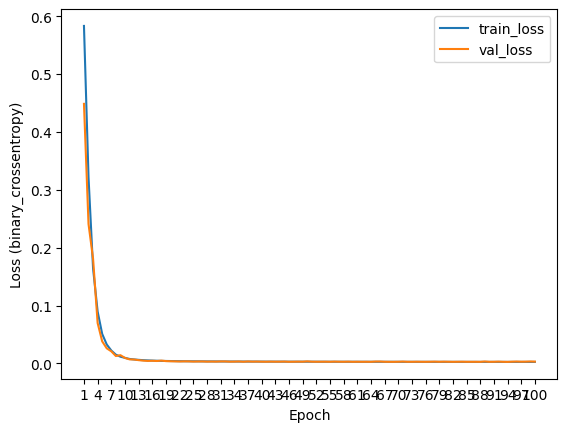

In [13]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = np.arange(1, len(loss) + 1)

plt.plot(epochs, loss, label='train_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss (binary_crossentropy)')
_ = plt.xticks(np.arange(1, len(loss) + 1, 3))

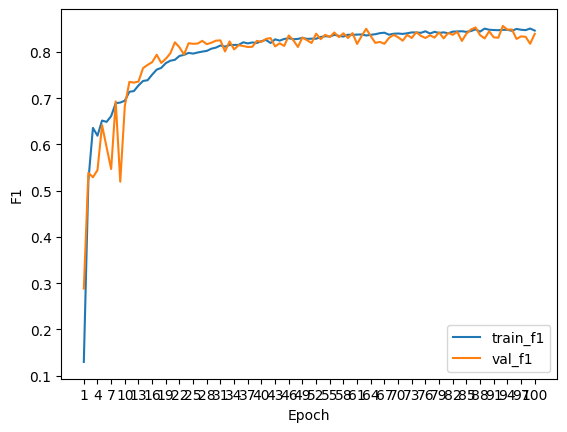

In [14]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
train_f1 = history.history['f1']
val_f1 = history.history['val_f1']

epochs = np.arange(1, len(train_f1) + 1)

plt.plot(epochs, train_f1, label='train_f1')
plt.plot(epochs, val_f1, label='val_f1')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1')
_ = plt.xticks(np.arange(1, len(loss) + 1, 3))

Convert model from server to run locally

In [5]:
# Paths
model_weights_path = r"C:\Users\Michon\Downloads\michongoddijn_231849_unet_model_it2_100epochs_256px.h5"
final_model_path = r"C:\Users\Michon\Downloads\final_modified_model.h5"

# Rebuild and save the model
patch_size = 256
model = advanced_unet_model_v2(patch_size, patch_size, 1)
model.load_weights(model_weights_path)  # Load weights
model.save(final_model_path)  # Save the full model
print(f"Model saved to: {final_model_path}")

c:\Users\Michon\anaconda3\envs\block2b\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model saved to: C:\Users\Michon\Downloads\final_modified_model.h5
